# Coursera Capstone Project - Battle of the Neighbourhood
## Hongfang Lu

This project will utilize Foursquare api to create visualization, do machine learning analysis.

London Moscow New York

In [89]:
import pandas as pd
import scipy
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import os
import pickle

from geopy.geocoders import Nominatim #convert address to latitude and longitude
from geopy import distance as ll_distance

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Get London neighbourhoods information

Get the list of areas in London through wikipedia page

In [2]:
page_london = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London')
page_london

<Response [200]>

Using Beautiful Soup to find the table that contains the neighbourhoods information

In [3]:
soup = BeautifulSoup(page_london.content, 'html.parser')
tables = soup.find_all('table', {'class': 'wikitable'})

Get the columns of the table, then remove all space (or unicode non-breaking sign), replace them with underscores

In [4]:
columns_row = tables[0].tbody.contents[0].children
columns_name = []
for co in columns_row:
    if co != '\n':
        #print(co.text)
        columns_name.append(co.text)

columns_name = map(lambda x: x.replace(u'\xa0', '_')
                   .replace(' ', '_').strip() 
                   if isinstance(x, (str, bytes)) 
                   else x, columns_name)

Get the columns names

In [5]:
columns_name = list(columns_name)
print(columns_name)

['Location', 'London_borough', 'Post_town', 'Postcode_district', 'Dial_code', 'OS_grid_ref']


Get the rows for each neighbourhood from the parsed webpage

In [6]:
locations = tables[0].tbody.contents[1:]

try:
    with open('london_raw.pkl', 'rb') as infile:
        all_data = pickle.load(infile)
except:
    all_data = []
    for location in locations:
        if location != '\n':
            #print(location)
            loc_data = []
            for co in location:
                if co != '\n':
                    #print(co.contents[0])
                    try: 
                        urll = co.contents[0]['href']
                        loc_data.append(urll)
                        loc_data.append(co.text.strip())
                    except:
                        loc_data.append(co.text.strip())
            all_data.append(loc_data)
    with open('london_raw.pkl', 'wb') as outfile:
        pickle.dump(all_data, outfile)

In [7]:
len(all_data)

533

These two utility functions transforms the coordinates to decimal.

the function `process_lan_lat()` transforms the coordinates from the form of '1.23N, 0.33W' into a list of the latitudes and longitudes, in the form of \[1.23, -0.33\]. 
the function `lat_long_to_dec()` transforms the coordinates from the form of """  37°12'12"S 122°45'23"W   """ into a list of the latitudes and longitudes, in the form of \[37.2033, 12.756389\]. The difference lies in whether to take care of the degree (°), minute ('), and second (") symbol.

In [8]:
def process_lan_lat(strn):
    strn = strn.strip()
    N_sign = True
    E_sign = True
    
    lat_p = strn.find('N')
    if lat_p == -1:
        N_sign = False
        lat_p = strn.find('S')
    
    lon_p = strn.find('E')
    if lon_p == -1:
        E_sign = False
        lon_p = strn.find('W')
    
    lat = strn[:(lat_p - 1)]
    lon = strn[(lat_p + 2):(lon_p - 1)]
    
    lat_sign = 1.0 if N_sign else -1.0
    lon_sign = 1.0 if E_sign else -1.0
    return [float(lat) * lat_sign, float(lon) * lon_sign]


def lat_long_to_dec(strn):
    strn = strn.strip()
    restemp = re.split('[°\'"′″ ]+', strn)
    
    #print(restemp)
    
    N_sign = 'N' in restemp
    E_sign = 'E' in restemp
    
    #print([N_sign, E_sign])
    
    if N_sign:
        lat_p = restemp.index('N')
    else:
        lat_p = restemp.index('S')
    
    if E_sign:
        lon_p = restemp.index('E')
    else:
        lon_p = restemp.index('W')
    
    #print([lat_p, lon_p])
    
    if lat_p == 1:
        lat = float(restemp[0])
    elif lat_p == 2:
        lat = float(restemp[0]) + float(restemp[1]) / 60
    elif lat_p == 3:
        lat = float(restemp[0]) + float(restemp[1]) / 60 + \
            float(restemp[2]) / 3600
    else:
        raise Exception('Wrong latitude format.')
    
    if (lon_p - lat_p) == 2:
        lon = float(restemp[lat_p + 1])
    elif (lon_p - lat_p) == 3:
        lon = float(restemp[lat_p + 1]) + float(restemp[lat_p + 2]) / 60
    elif (lon_p - lat_p) == 4:
        lon = float(restemp[lat_p + 1]) + float(restemp[lat_p + 2]) / 60 + \
            float(restemp[lat_p + 3]) / 3600
    else:
        raise Exception('Wrong longitude format.')
    
    #print([lat, lon])
    
    lat_sign = 1.0 if N_sign else -1.0
    lon_sign = 1.0 if E_sign else -1.0
    return [float(lat) * lat_sign, float(lon) * lon_sign]

Parse wikipedia pages of each neighbourhood, then get the geograpical coordinate

In [9]:
%%time
lat_lon_all = [None for i in range(len(all_data))]

for i in range(len(all_data)):
    urll = 'https://en.wikipedia.org' + all_data[i][0]
    page = requests.get(urll)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    
    lls = soup.find_all('span', {'class': 'geo-dec'})
    if len(lls) > 0:
        print(all_data[i][1])
        print(lls[0].text)

        lat_lon_all[i] = str(lls[0].text)


Abbey Wood
51.4864°N 0.1109°E
Acton
51.513519°N 0.270661°W
Addington
51.3583°N 0.0305°W
Addiscombe
51.381°N 0.0663°W
Albany Park
51.4264°N 0.1026°E
Aldborough Hatch
51.583550°N 0.10102165°E
Aldgate
51.5132°N 0.0777°W
Aldwych
51.5132°N 0.1167°W
Alperton
51.5405°N 0.2994°W
Anerley
51.4147°N 0.067°W
Angel
51.5321°N 0.1066°W
Aperfield
51.3069°N 0.0448°E
Archway
51.566°N 0.1338°W
Ardleigh Green
51.5833°N 0.2165°E
Arkley
51.6477°N 0.2311°W
Arnos Grove
51.6163°N 0.1286°W
Balham
51.4434°N 0.1525°W
Bankside
51.5082°N 0.1001°W
Barbican
51.51917°N 0.09389°W
Barking
51.54°N 0.08°E
Barkingside
51.585833°N 0.084444°E
Barnehurst
51.4613°N 0.1690°E
Barnes
51.474°N 0.236°W
Barnes Cray
51.4578°N 0.1960°E
Barnet Gate
51.643083°N 0.240570°W
Barnet (also Chipping Barnet, High Barnet)
51.6444°N 0.1997°W
Barnsbury
51.5442°N 0.1171°W
Battersea
51.46377°N 0.16771°W
Bayswater
51.5095°N 0.1929°W
Beckenham
51.408°N 0.022°W
Beckton
51.5146°N 0.0673°E
Becontree
51.5487°N 0.1427°E
Becontree Heath
51.563595°N 0.15261

Knightsbridge
51.5017°N 0.1621°W
Ladywell
51.453°N 0.017°W
Lambeth
51.4903°N 0.1193°W
Lamorbey
51.438333°N 0.107549°E
Lampton
51.478109°N 0.363268°W
Lea Bridge
51.5621°N 0.0456°W
Leamouth
51.510719°N 0.006317°E
Leaves Green
51.335384°N 0.02952°E
Lee
51.4522°N 0.0086°E
Lessness Heath
51.4857°N 0.15177°E
Lewisham
51.461°N 0.005°W
Leyton
51.560558°N 0.015465°W
Leytonstone
51.569°N 0.010°E
Limehouse
51.5158°N 0.0318°W
Lisson Grove
51.52539°N 0.16969°W
Little Ilford
51.5509°N 0.0549°E
Little Venice
51.5216°N 0.1821°W
Locksbottom
51.3708°N 0.0608°E
Longford
51.4777°N 0.4943°W
Longlands
51.4302°N 0.0854°E
Lower Clapton
51.55212°N 0.04704°W
Lower Morden
51.3884°N 0.2198°W
Loxford
51.54807°N 0.08184°E
Maida Vale
51.5274°N 0.1899°W
Malden Rushett
51.336769°N 0.320285°W
Manor House
51.57182°N 0.09671°W
Manor Park
51.55033°N 0.056219°E
Marks Gate
51.593°N 0.1448°E
Maryland
51.545°N 0.002°W
Marylebone (also St Marylebone)
51.5177°N 0.1470°W
Mayfair
51.508755°N 0.14743°W
Maze Hill
51.481209°N 0.0036

Transform the geographical coordinates into lists

In [10]:
%%time
for i in range(len(all_data)):
    if lat_lon_all[i]:
        lat_lon = process_lan_lat(lat_lon_all[i])
    else:
        lat_lon = [None, None]
    
    all_data[i].extend(lat_lon)

Wall time: 2 ms


Create the dataframe.

In [11]:
london_df = pd.DataFrame(all_data, columns=['Link'] + columns_name + ['Latitude', 'Longitude'])
london_df.head()

,Link,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longitude
0,/wiki/Abbey_Wood,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785,51.486400,0.110900
1,"/wiki/Acton,_London",Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805,51.513519,-0.270661
2,"/wiki/Addington,_London",Addington,Croydon[2],CROYDON,CR0,020,TQ375645,51.358300,-0.030500
3,/wiki/Addiscombe,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665,51.381000,-0.066300
4,"/wiki/Albany_Park,_Bexley",Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.426400,0.102600


There are some rows that don't have the latitude/longitude information, which is line 109 and 355.

In [12]:
london_df[london_df['Latitude'].isnull()]

,Link,Location,London_borough,Post_town,Postcode_district,Dial_code,OS_grid_ref,Latitude,Longitude
109,/wiki/Colyers_(ward),Colyers,Bexley,ERITH,DA8,01322,TQ512768,NaN,NaN
355,/wiki/Oval,Oval,Lambeth,LONDON,"SW8, SW9, SE11",020,TQ315575,NaN,NaN


Remove the rows with NaN values.

In [13]:
london_df.dropna(axis=0, inplace=True)

In [14]:
london_df.shape

(531, 9)

In [15]:
address = 'London, England'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

london_lon_lat = [latitude, longitude]

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [58]:
london = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)

for lat, lng, borough, neighborhood in zip(london_df['Latitude'], \
                                           london_df['Longitude'], \
                                           london_df['London_borough'], \
                                           london_df['Location']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london)  
    
london

## 2. Get Moscow information

In [17]:
page_mos = requests.get('https://en.wikipedia.org/wiki/Administrative_divisions_of_Moscow')
page_mos

<Response [200]>

In [18]:
soup_mos = BeautifulSoup(page_mos.content, 'html.parser')
tables_mos = soup_mos.find_all('div', attrs={"aria-labelledby": "Administrative_divisions_of_Moscow"})

In [19]:
tables_mos_det = tables_mos[0].table.tbody.contents[1:11]

In [20]:
listss = tables_mos_det[0].td.find_all('li')
listss[0].text

'Arbat'

In [21]:
%%time
try:
    with open('moscow_raw.pkl', 'rb') as infile:
        all_data_mos = pickle.load(infile)
except:
    all_data_mos = []
    for okrug in tables_mos_det:
        okrug_name = okrug.th.text
        okrug_link = okrug.th.a['href']
        divis = []
        for divi in okrug.td.find_all('li'):
            divi_link = divi.a['href']
            divi_name = divi.text
            divis.append([divi_link, divi_name, okrug_link, okrug_name])
        all_data_mos.extend(divis)
        
    with open('moscow_raw.pkl', 'wb') as outfile:
        pickle.dump(all_data_mos, outfile)

Wall time: 14 ms


In [22]:
len(all_data_mos)

125

In [23]:
%%time
lat_lon_all_mos = [None for i in range(len(all_data_mos))]

for i in range(len(all_data_mos)):
    urll = 'https://en.wikipedia.org' + all_data_mos[i][0]
    page = requests.get(urll)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    
    lls = soup.find_all('span', {'class': 'geo-dec'})
    if len(lls) > 0:
        print(all_data_mos[i][1])
        print(lls[0].text)

        lat_lon_all_mos[i] = str(lls[0].text)

Arbat
55.751°N 37.590°E
Basmanny
55.7649472°N 37.6715833°E
Khamovniki
55.72611°N 37.57111°E
Krasnoselsky
55.77861°N 37.65639°E
Meshchansky
55.77583°N 37.62750°E
Presnensky
55.74667°N 37.53694°E
Tagansky
55.74139°N 37.65417°E
Tverskoy
55.767°N 37.600°E
Yakimanka
55.73139°N 37.60389°E
Zamoskvorechye
55.73972°N 37.62500°E
Aeroport
55.79139°N 37.55944°E
Begovoy
55.78667°N 37.57556°E
Beskudnikovsky
55.86528°N 37.56500°E
Dmitrovsky
55.88861°N 37.52361°E
Golovinsky
55.84583°N 37.51694°E
Khoroshyovsky
55.78833°N 37.52944°E
Khovrino
55.87222°N 37.50472°E
Koptevo
55.83333°N 37.51889°E
Levoberezhny
55.867°N 37.467°E
Molzhaninovsky
55.93083°N 37.38917°E
Savyolovsky
55.81028°N 37.56250°E
Sokol
55.800°N 37.500°E
Timiryazevsky
55.82028°N 37.56000°E
Vostochnoye Degunino
55.87306°N 37.56889°E
Voykovsky
55.817°N 37.500°E
Zapadnoye Degunino
55.8652806°N 37.5366694°E
Alexeyevsky
55.817°N 37.650°E
Altufyevsky
55.87972°N 37.58417°E
Babushkinsky
55.86972°N 37.66444°E
Bibirevo
55.89167°N 37.61667°E
Butyrsky
5

In [24]:
%%time
for i in range(len(all_data_mos)):
    if lat_lon_all_mos[i]:
        lat_lon = process_lan_lat(lat_lon_all_mos[i])
    else:
        lat_lon = [None, None]
    
    all_data_mos[i].extend(lat_lon)

Wall time: 1 ms


In [25]:
moscow_df = pd.DataFrame(all_data_mos, columns=['Link', 'Location', 'OLink', 'OLocation', 'Latitude', 'Longitude'])
moscow_df.head()

,Link,Location,OLink,OLocation,Latitude,Longitude
0,/wiki/Arbat_District,Arbat,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.751000,37.590000
1,/wiki/Basmanny_District,Basmanny,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.764947,37.671583
2,/wiki/Khamovniki_District,Khamovniki,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.726110,37.571110
3,"/wiki/Krasnoselsky_District,_Moscow",Krasnoselsky,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.778610,37.656390
4,/wiki/Meshchansky_District,Meshchansky,/wiki/Central_Administrative_Okrug,Central Administrative Okrug,55.775830,37.627500


In [26]:
moscow_df.dropna(axis=0, inplace=True)
moscow_df.shape

(125, 6)

In [27]:
address = 'Moscow, Russia'

geolocator = Nominatim(user_agent="mos_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Moscow are {}, {}.'.format(latitude, longitude))

moscow_lon_lat = [latitude, longitude]

The geograpical coordinate of Moscow are 55.7504461, 37.6174943.


In [59]:
moscow = folium.Map(location=moscow_lon_lat, zoom_start=10, control_scale=True)

for lat, lng, borough, neighborhood in zip(moscow_df['Latitude'], \
                                           moscow_df['Longitude'], \
                                           moscow_df['Location'], \
                                           moscow_df['OLocation']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(moscow)  
    
moscow

## 3. Get the neighhourhoods of San Francisco

In [29]:
page_san = requests.get('https://en.wikipedia.org/wiki/Category:Neighborhoods_in_San_Francisco')
page_san

<Response [200]>

In [30]:
soup_san = BeautifulSoup(page_san.content, 'html.parser')
tables_san = soup_san.find_all('div', attrs={"class": "mw-category"})
tables_san = tables_san[1]
tables_san = tables_san.contents[1:]

In [31]:
tables_san[0].ul.find_all('li')

[<li><a href="/wiki/Alamo_Square,_San_Francisco" title="Alamo Square, San Francisco">Alamo Square, San Francisco</a></li>,
 <li><a href="/wiki/Alta_Plaza" title="Alta Plaza">Alta Plaza</a></li>,
 <li><a href="/wiki/Anza_Vista,_San_Francisco" title="Anza Vista, San Francisco">Anza Vista, San Francisco</a></li>]

In [32]:
%%time
try:
    with open('sanfra_raw.pkl', 'rb') as infile:
        all_data_san = pickle.load(infile)
except:
    all_data_san = []
    for letters in tables_san:
        for loc in letters.ul.find_all('li'):
            loc_name = loc.text
            loc_link = loc.a['href']
            all_data_san.append([loc_link, loc_name])
    with open('sanfra_raw.pkl', 'wb') as outfile:
        pickle.dump(all_data_san, outfile)
len(all_data_san)

Wall time: 50.5 ms


In [33]:
%%time
lat_lon_all_san = [None for i in range(len(all_data_san))]

for i in range(len(all_data_san)):
    urll = 'https://en.wikipedia.org' + all_data_san[i][0]
    page = requests.get(urll)
    
    soup = BeautifulSoup(page.content, 'html.parser')
    
    lls = soup.find_all('span', {'class': 'geo-dms'})
    if len(lls) > 0:
        print(all_data_san[i][1])
        print(lls[0].text)

        lat_lon_all_san[i] = str(lls[0].text)

Alamo Square, San Francisco
37°46′35″N 122°26′05″W
Alta Plaza
37°47′28″N 122°26′16″W
Anza Vista, San Francisco
37°46′51″N 122°26′35″E
Balboa Park, San Francisco
37°43′30″N 122°26′42″W
Balboa Terrace, San Francisco
37°43′53″N 122°28′07″W
Barbary Coast, San Francisco
37°47′48″N 122°24′21″W
Bayview–Hunters Point, San Francisco
37°43′37″N 122°23′19″W
Bayview, San Francisco, California
37°43′37″N 122°23′19″W
Bernal Heights, San Francisco
37°44′30″N 122°24′52″W
Carville, San Francisco
37°45′24″N 122°30′24″W
Castro District, San Francisco
37°45′42″N 122°26′06″W
Cathedral Hill, San Francisco
37°47′03″N 122°25′31″W
Central Embarcadero Piers Historic District
37°47′58″N 122°23′42″W
Chinatown, San Francisco
37°47′41″N 122°24′26″W
Civic Center, San Francisco
37°46′45″N 122°24′57″W
Cole Valley, San Francisco
37°45′53″N 122°26′59″W
Corona Heights, San Francisco
37°45′45.1″N 122°24′35.5″W
Crocker-Amazon, San Francisco
37°42′46″N 122°26′22″W
Diamond Heights, San Francisco
37°44′45″N 122°26′30″W
Dogpat

In [34]:
%%time
for i in range(len(all_data_san)): 
    if lat_lon_all_san[i]:
        if '°' in lat_lon_all_san[i]:
            lat_lon = lat_long_to_dec(lat_lon_all_san[i])
        else:
            lat_lon = process_lan_lat(lat_lon_all_san[i])
    else:
        lat_lon = [None, None]
    
    all_data_san[i].extend(lat_lon)

Wall time: 1 ms


In [184]:
sanfra_df = pd.DataFrame(all_data_san, columns=['Link', 'Location', 'Latitude', 'Longitude'])
sanfra_df.loc[2, 'Longitude'] = -sanfra_df.loc[2, 'Longitude']
sanfra_df.head()

,Link,Location,Latitude,Longitude
0,"/wiki/Alamo_Square,_San_Francisco","Alamo Square, San Francisco",37.776389,-122.434722
1,/wiki/Alta_Plaza,Alta Plaza,37.791111,-122.437778
2,"/wiki/Anza_Vista,_San_Francisco","Anza Vista, San Francisco",37.780833,-122.443056
3,"/wiki/Balboa_Park,_San_Francisco","Balboa Park, San Francisco",37.725000,-122.445000
4,"/wiki/Balboa_Terrace,_San_Francisco","Balboa Terrace, San Francisco",37.731389,-122.468611


In [189]:
sanfra_df.dropna(axis=0, inplace=True)
sanfra_df.shape

(88, 4)

In [37]:
address = 'San Francisco, United States'

geolocator = Nominatim(user_agent="san_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of San Francisco are {}, {}.'.format(latitude, longitude))

sanfra_lon_lat = [latitude, longitude]

The geograpical coordinate of San Francisco are 37.7792808, -122.4192363.


In [56]:
sanfra = folium.Map(location=sanfra_lon_lat, zoom_start=12, control_scale=True)

for lat, lng, borough in zip(sanfra_df['Latitude'], \
                                           sanfra_df['Longitude'], \
                                           sanfra_df['Location']):
    label = borough
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sanfra)  
    
sanfra

## 4. Use foursquare api to collect venue informations on each point

In [193]:
london_df.reset_index(inplace=True)
moscow_df.reset_index(inplace=True)
sanfra_df.reset_index(inplace=True)

In [57]:
import os

CLIENT_ID = os.environ['FS_ID']
CLIENT_SECRET = os.environ['FS_SECRET'] 
VERSION = '20190501'

### London venues
The neighbourhood centers are scattered around, first we need to calculate the average the distances between venues, which will be fed into foursquare api for exploring the neighbourhoods.

In [105]:
coordinates_london = london_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_london)

In [112]:
%%time
london_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_london.loc[p0, :], 
                              coordinates_london.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_london.loc[p0, :], 
                              coordinates_london.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_london.loc[p1, :], 
                              coordinates_london.loc[p2, :]).km * 1000
    london_dis.extend([d1, d2, d3])
london_dis_mean = np.floor(np.mean(london_dis) / 600) * 600
print(london_dis_mean)

Wall time: 2.13 s


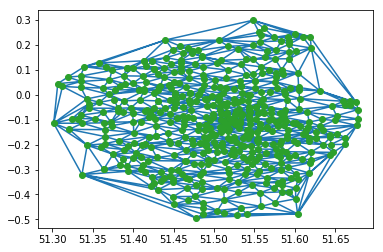

In [101]:
plt.triplot(coordinates_london.loc[:, 'Latitude'], coordinates_london.loc[:, 'Longitude'], tri.simplices.copy())
plt.plot(coordinates_london.loc[:, 'Latitude'], coordinates_london.loc[:, 'Longitude'], 'o')
plt.show()

In [138]:
%%time
try:
    with open('results_london.pkl', 'rb') as infile:
        results_london = pickle.load(infile)

except:
    results_london = [None for i in range(london_df.shape[0])]

    radius = london_dis_mean
    LIMIT = 200

    for location_id in range(0, london_df.shape[0]):
        idd = location_id
        sp_name = london_df.loc[idd, 'Location']
        sp_la = london_df.loc[idd, 'Latitude']
        sp_lo = london_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_london[location_id] = result
        print(str(location_id) + ' is written')

    with open('results_london.pkl', 'wb') as outfile:
        pickle.dump(results_london, outfile)

0 is written
1 is written
2 is written
3 is written
4 is written
5 is written
6 is written
7 is written
8 is written
9 is written
10 is written
11 is written
12 is written
13 is written
14 is written
15 is written
16 is written
17 is written
18 is written
19 is written
20 is written
21 is written
22 is written
23 is written
24 is written
25 is written
26 is written
27 is written
28 is written
29 is written
30 is written
31 is written
32 is written
33 is written
34 is written
35 is written
36 is written
37 is written
38 is written
39 is written
40 is written
41 is written
42 is written
43 is written
44 is written
45 is written
46 is written
47 is written
48 is written
49 is written
50 is written
51 is written
52 is written
53 is written
54 is written
55 is written
56 is written
57 is written
58 is written
59 is written
60 is written
61 is written
62 is written
63 is written
64 is written
65 is written
66 is written
67 is written
68 is written
69 is written
70 is written
71 is written
72

In [140]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [147]:
%%time

try:
    with open('venues_london.pkl', 'rb') as infile:
        venues_london = pickle.load(infile)

except:
    venues_london = [None for i in range(london_df.shape[0])]

    for i in range(london_df.shape[0]):
        print(i)
        if results_london[i]['response']:
            venues = results_london[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            print(nearby_venues.shape)

            venues_london[i] = nearby_venues
    with open('venues_london.pkl', 'wb') as outfile:
        pickle.dump(venues_london, outfile)

0
(20, 4)
1
(100, 4)
2
(19, 4)
3
(31, 4)
4
(38, 4)
5
(31, 4)
6
(100, 4)
7
(100, 4)
8
(69, 4)
9
(96, 4)
10
(100, 4)
11
(9, 4)
12
(100, 4)
13
(29, 4)
14
(14, 4)
15
(81, 4)
16
(100, 4)
17
(100, 4)
18
(100, 4)
19
(41, 4)
20
(44, 4)
21
(59, 4)
22
(100, 4)
23
(30, 4)
24
(11, 4)
25
(41, 4)
26
(100, 4)
27
(100, 4)
28
(100, 4)
29
(61, 4)
30
(59, 4)
31
(28, 4)
32
(27, 4)
33
(70, 4)
34
(100, 4)
35
(100, 4)
36
(55, 4)
37
(36, 4)
38
(10, 4)
39
(100, 4)
40
(11, 4)
41
(100, 4)
42
(81, 4)
43
(100, 4)
44
(44, 4)
45
(59, 4)
46
(22, 4)
47
(9, 4)
48
(20, 4)
49
(100, 4)
50
(100, 4)
51
(100, 4)
52
(100, 4)
53
(26, 4)
54
(100, 4)
55
(13, 4)
56
(100, 4)
57
(100, 4)
58
(100, 4)
59
(95, 4)
60
(100, 4)
61
(93, 4)
62
(27, 4)
63
(100, 4)
64
(100, 4)
65
(63, 4)
66
(100, 4)
67
(28, 4)
68
(100, 4)
69
(100, 4)
70
(56, 4)
71
(26, 4)
72
(74, 4)
73
(100, 4)
74
(100, 4)
75
(100, 4)
76
(100, 4)
77
(100, 4)
78
(97, 4)
79
(65, 4)
80
(100, 4)
81
(64, 4)
82
(100, 4)
83
(28, 4)
84
(98, 4)
85
(31, 4)
86
(100, 4)
87
(100, 4)
88
(

In [155]:
venues_london_total = pd.concat(venues_london, axis=0)
venues_london_total.reset_index()
venues_london_total.shape

(36627, 4)

In [162]:
test_rg = np.random.choice(venues_london_total.shape[0], 1000, replace=False)
test_df = venues_london_total.iloc[test_rg, :]
test_df.head()

,name,categories,lat,lng
6,Pizza Express,Pizza Place,51.426384,0.100280
10,Departure Lounge,Airport Terminal,51.473418,-0.487583
32,The Goring Hotel,Hotel,51.497442,-0.145724
19,Café Rouge,French Restaurant,51.576558,-0.427070
13,Westfield Stratford City,Shopping Mall,51.542892,-0.006909


In [163]:
test1 = folium.Map(location=london_lon_lat, zoom_start=11, control_scale=True)

test_df = venues_london_total.iloc[test_rg, :]
for lat, lng, name, cat in zip(test_df['lat'], \
                                           test_df['lng'], \
                                           test_df['name'], \
                                           test_df['categories']):
    label = '{}, {}'.format(name, cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.3,
        parse_html=False).add_to(test1)  
    
test1

### Moscow Venues

In [164]:
coordinates_moscow = moscow_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_moscow)

In [167]:
%%time
moscow_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_moscow.loc[p0, :], 
                              coordinates_moscow.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_moscow.loc[p0, :], 
                              coordinates_moscow.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_moscow.loc[p1, :], 
                              coordinates_moscow.loc[p2, :]).km * 1000
    moscow_dis.extend([d1, d2, d3])
moscow_dis_mean = np.floor(np.mean(moscow_dis) / 600) * 600
print(moscow_dis_mean)

4200.0
Wall time: 601 ms


In [168]:
%%time
try:
    with open('results_moscow.pkl', 'rb') as infile:
        results_moscow = pickle.load(infile)
except:
    results_moscow = [None for i in range(moscow_df.shape[0])]

    radius = moscow_dis_mean
    LIMIT = 200

    for location_id in range(0, moscow_df.shape[0]):
        idd = location_id
        sp_name = moscow_df.loc[idd, 'Location']
        sp_la = moscow_df.loc[idd, 'Latitude']
        sp_lo = moscow_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_moscow[location_id] = result
        print(str(location_id) + ' is written')
    with open('results_moscow.pkl', 'wb') as outfile:
        pickle.dump(results_moscow, outfile)

0 is written
1 is written
2 is written
3 is written
4 is written
5 is written
6 is written
7 is written
8 is written
9 is written
10 is written
11 is written
12 is written
13 is written
14 is written
15 is written
16 is written
17 is written
18 is written
19 is written
20 is written
21 is written
22 is written
23 is written
24 is written
25 is written
26 is written
27 is written
28 is written
29 is written
30 is written
31 is written
32 is written
33 is written
34 is written
35 is written
36 is written
37 is written
38 is written
39 is written
40 is written
41 is written
42 is written
43 is written
44 is written
45 is written
46 is written
47 is written
48 is written
49 is written
50 is written
51 is written
52 is written
53 is written
54 is written
55 is written
56 is written
57 is written
58 is written
59 is written
60 is written
61 is written
62 is written
63 is written
64 is written
65 is written
66 is written
67 is written
68 is written
69 is written
70 is written
71 is written
72

In [170]:
%%time
try:
    with open('venues_moscow.pkl', 'rb') as infile:
        venues_moscow = pickle.load(infile)

except:
    venues_moscow = [None for i in range(moscow_df.shape[0])]

    for i in range(moscow_df.shape[0]):
        if results_moscow[i]['response']:
            venues = results_moscow[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            print(nearby_venues.shape)

            venues_moscow[i] = nearby_venues
        
    with open('venues_moscow.pkl', 'wb') as outfile:
        pickle.dump(venues_moscow, outfile)

(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(67, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(84, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(79, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(96, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(94, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(86, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(100, 4)
(76, 4)
(100, 4)
(100, 4)
(100, 4)
(84, 4)
(100, 4)
(100, 4)


### San Francisco Venues

In [194]:
coordinates_sanfra = sanfra_df[['Latitude', 'Longitude']]
tri = scipy.spatial.Delaunay(coordinates_sanfra)

In [195]:
coordinates_sanfra

,Latitude,Longitude
0,37.776389,-122.434722
1,37.791111,-122.437778
2,37.780833,-122.443056
3,37.725000,-122.445000
4,37.731389,-122.468611
5,37.796667,-122.405833
6,37.726944,-122.388611
7,37.726944,-122.388611
8,37.741667,-122.414444
9,37.756667,-122.506667


In [196]:
%%time
sanfra_dis = []
for p0, p1, p2 in tri.simplices:
    d1 = ll_distance.distance(coordinates_sanfra.loc[p0, :], 
                              coordinates_sanfra.loc[p1, :]).km * 1000
    d2 = ll_distance.distance(coordinates_sanfra.loc[p0, :], 
                              coordinates_sanfra.loc[p2, :]).km * 1000
    d3 = ll_distance.distance(coordinates_sanfra.loc[p1, :], 
                              coordinates_sanfra.loc[p2, :]).km * 1000
    sanfra_dis.extend([d1, d2, d3])
sanfra_dis_mean = np.floor(np.mean(sanfra_dis) / 600) * 600
print(sanfra_dis_mean)

1200.0
Wall time: 368 ms


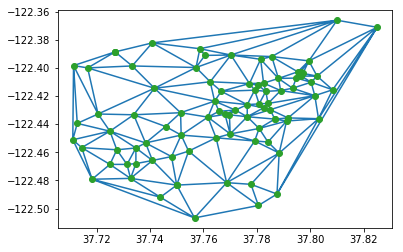

In [197]:
plt.triplot(coordinates_sanfra.loc[:, 'Latitude'], coordinates_sanfra.loc[:, 'Longitude'], tri.simplices.copy())
plt.plot(coordinates_sanfra.loc[:, 'Latitude'], coordinates_sanfra.loc[:, 'Longitude'], 'o')
plt.show()

In [199]:
%%time
try:
    with open('results_sanfra.pkl', 'rb') as infile:
        results_sanfra = pickle.load(infile)
except:
    results_sanfra = [None for i in range(sanfra_df.shape[0])]

    radius = sanfra_dis_mean
    LIMIT = 200

    for location_id in range(0, sanfra_df.shape[0]):
        idd = location_id
        sp_name = sanfra_df.loc[idd, 'Location']
        sp_la = sanfra_df.loc[idd, 'Latitude']
        sp_lo = sanfra_df.loc[idd, 'Longitude']

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                        CLIENT_ID, \
                                        CLIENT_SECRET, \
                                        sp_la, \
                                        sp_lo, \
                                        VERSION, \
                                        radius, \
                                        LIMIT)
        result = requests.get(url).json()
        results_sanfra[location_id] = result
        print(str(location_id) + ' is written')
    with open('results_sanfra.pkl', 'wb') as outfile:
        pickle.dump(results_sanfra, outfile)

Wall time: 127 ms


In [202]:
%%time
try:
    with open('venues_sanfra.pkl', 'rb') as infile:
        venues_sanfra = pickle.load(infile)

except:
    venues_sanfra = [None for i in range(sanfra_df.shape[0])]

    for i in range(sanfra_df.shape[0]):
        if results_sanfra[i]['response']:
            venues = results_sanfra[i]['response']['groups'][0]['items']

            nearby_venues = json_normalize(venues) # flatten JSON

            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues = nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

            print(nearby_venues.shape)

            venues_sanfra[i] = nearby_venues
        
    with open('venues_sanfra.pkl', 'wb') as outfile:
        pickle.dump(venues_sanfra, outfile)

Wall time: 44 ms


Explanation

In [ ]:


'''
east_toronto_name = toronto_data.loc[0, 'Neighbourhood']
east_toronto_la = toronto_data.loc[0, 'Latitude']
east_toronto_lo = toronto_data.loc[0, 'Longitude']
'''


In [ ]:
'''
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(\
                                CLIENT_ID, \
                                CLIENT_SECRET, \
                                east_toronto_la, \
                                east_toronto_lo, \
                                VERSION, \
                                radius, \
                                LIMIT)

url
'''